In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np #Numpy
import json

In [10]:
repo_path = '/Users/gkeating/repo/sma_phasing_sims'
filename = 'phasing_data/vlbi_cal.099-2021.json'

# Read the data in
with open(os.path.join(repo_path, filename)) as json_file:
    swarm_data = json.load(json_file)

In [11]:
# Grab the total length of the data real quick
n_data = len(swarm_data)

# We're gonna be doing a lot of diff operations, which means in some cases we'll want
# to pad some arrays with zeros. Construct some arrays now for the sake of convenience
zero_pad = [
    np.zeros((1,len(swarm_data[0]['phases_lsb']))),
    np.zeros((1,len(swarm_data[0]['phases_usb']))),
]

# These are the implemented phase values recorded in SWARM
phases_lsb = np.array([swarm_data[idx]['phases_lsb'] for idx in range(n_data)])
phases_usb = np.array([swarm_data[idx]['phases_usb'] for idx in range(n_data)])

# These are the derived offsets/error terms for each antenna, given the implemented values
cal_solution_lsb = np.array([swarm_data[idx]['cal_solution_lsb'][2] for idx in range(n_data)])
cal_solution_usb = np.array([swarm_data[idx]['cal_solution_usb'][2] for idx in range(n_data)])

# Let's calculate the "true" phase -- that is, assume that the solutions are perfect, and
# use that to figure out what the antenna phase should _actually_ have been at time of obs.
# There's kind of a funny padding operation that's needed here because of the order values
# in the JSON file are recorded (soln's derived -> values implemented -> values recorded).
true_phase_lsb = phases_lsb[:-1] + cal_solution_lsb[1:]
true_phase_usb = phases_usb[:-1] + cal_solution_usb[1:]

# Convert times from UNIX -> fractional UTC hours
time_stamps = (np.array([swarm_data[idx]['int_time'] for idx in range(n_data)]) % 86400) / 3600.0

In [12]:
kp = .75  #Proportional Gain - SWARM default is 0.75
kd = .01  #Derivative Gain - SWARM default is 0.01
ki = .05  #Integral Gain  - SWARM default is 0.05

# The parameter below effectively controls how long a window over which the
# integral term is calculated -- in SWARM, the default is 8 integrations.
int_length = 8

p_vals = cal_solution_usb.copy()
i_vals = cal_solution_usb.copy()
for idx in range(1, int_length):
    i_vals[idx:] += cal_solution_usb[:-idx]
d_vals = np.concatenate((zero_pad[1], np.diff(cal_solution_usb, axis=0)))

In [29]:
pid_sim = p_vals*kp + i_vals*ki + d_vals*kd

# This unwrapping of the phase angle is done here to eliminate any wraps which may look
# like big spikes in the PID response.
pid_sim = (((pid_sim + 180.0) % 360.0) - 180.0)

# To calculate what the online PID servo loop was doing, take the difference between
# the implemented phases in subsequent integrations, via numpy's diff operation. We 
# do the same wrapping here to make sure that everything is in the same range.
pid_response_lsb = ((np.diff(phases_lsb, axis=0) + 180.0) % 360.0) - 180.0

pid_response_usb = ((np.diff(phases_usb, axis=0) + 180.0) % 360.0) - 180.0

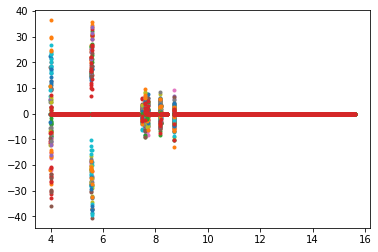

In [31]:
# Lo and behold, the magic of the simulation!
_ = plt.plot(time_stamps[1:], pid_sim[1:] - pid_response_usb, '.')

Note that the big spikes above are actually being caused by the phasing loop being turned on and off, as part of normal array operations. Each dataset likely contains a few integrations like this -- we could try to manually excise them, or for now, just ignore them, since they only contaminate a very small fraction of the data.

In [7]:
# Finally, let's see what happens if we tweak values
# Begin skeleton code!
int_length = 8  # Integral length - SWARM default is 8
kp = 0.75       # Proportional Gain - SWARM default is 0.75
ki = .05        # Integral Gain  - SWARM default is 0.05
kd = .01        # Derivative Gain - SWARM default is 0.01

int_window = np.zeros((int_length, true_phase_usb.shape[1]))
new_epsilon = np.zeros(true_phase_usb.shape)
last_cal = true_phase_usb[0]

for idx in range(n_data):
    cal_soln = (((true_phase_usb[idx] - last_cal) + 180.0 ) % 360.0) - 180.0
    new_epsilon[idx] = cal_soln
    int_window = np.roll(int_window, 1, axis=0)
    int_window[0] = cal_soln
    
    pid_response = (
        (kp * cal_soln)
        + (int_window.sum(axis=0) * ki)
        + ((int_window[0] - int_window[1]) * kd)
    )
    last_cal += pid_response
    last_cal = ((last_cal + 180.0 ) % 360.0) - 180.0